In [1]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [193]:
from os import getcwd
from os.path import join

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils import class_weight

import xgboost as xgb

from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, precision_recall_curve
from sklearn.metrics import make_scorer, fbeta_score

In [5]:
random.seed(42)

work_dir = getcwd()
data_dir = join(work_dir, "data")
image_dir = join(work_dir, "images")

In [6]:
fraud_data = pd.read_csv(join(data_dir, "fraud_data_country.csv"), index_col=0) 

## Preprocessing

In [7]:
quantile_list = [0, .25, .5, .75, 1.]

top5_country = ['United States', 'unknown', 'China', 'Japan', 'United Kingdom',
       'Korea Republic of']

def country_reduction(country):
    """
    Réduction du nombre de country au top5
    """
    if np.isin(country, top5_country):
        return country
    else:
        return "other"

def quantile_labels(feature_quantiles):
    """
    return the list of the feature quantiles labels
    """
    return [f"{int(feature_quantiles.iloc[q])}-{int(feature_quantiles.iloc[q+1])}" for q in range(len(feature_quantiles) - 1)]

def preprocessing(df, dummies_drop_first=True):
    """
    Procédure de préparation des features
    """
    
    # conversion de l'ip_address en int64
    df["ip_address"] = fraud_data["ip_address"].astype("int64")
    
    # time conversion
    df["signup_time"] = pd.to_datetime(df["signup_time"], infer_datetime_format=True)
    df["purchase_time"] = pd.to_datetime(df["purchase_time"], infer_datetime_format=True)
    
    # création de la feature délai signup purchase
    df["signup_purchase_timedelta"] = df["purchase_time"] - df["signup_time"]
    df["signup_purchase_timedelta"] = df["signup_purchase_timedelta"].dt.total_seconds() / 60
    
    # création de la feature jour de la semaine de la transaction
    df["purchase_weekday"] = df["purchase_time"].dt.weekday
    
    # création de la feature heure de la transaction
    df["purchase_hour"] = df["purchase_time"].dt.hour
    hour_quantiles = df["purchase_hour"].quantile(quantile_list)
    hour_bins_labels = quantile_labels(hour_quantiles)
    df["purchase_hour"] = pd.qcut(df["purchase_hour"], q=quantile_list, labels=hour_bins_labels)
    
    # discretisation Age
    #age_quantiles = df["age"].quantile(quantile_list)
    #age_bins_labels = quantile_labels(age_quantiles)
    #df["age"] = pd.qcut(df["age"], q=quantile_list, labels=age_bins_labels)
    
     
    # réduction du nombre de classes de country
    df["country"] = df["country"].map(country_reduction)
    
    # dummification
    # sex, source, browser, age
    df = pd.get_dummies(df, 
                        columns=["sex", "source","browser", 
                                 #"age", 
                                 "country", "purchase_weekday", "purchase_hour"], 
                        drop_first=dummies_drop_first)
    
    return df

In [8]:
df = preprocessing(fraud_data.copy(), False)

In [9]:
df.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'age', 'ip_address', 'class', 'signup_purchase_timedelta',
       'sex_F', 'sex_M', 'source_Ads', 'source_Direct', 'source_SEO',
       'browser_Chrome', 'browser_FireFox', 'browser_IE', 'browser_Opera',
       'browser_Safari', 'country_China', 'country_Japan',
       'country_Korea Republic of', 'country_United Kingdom',
       'country_United States', 'country_other', 'country_unknown',
       'purchase_weekday_0', 'purchase_weekday_1', 'purchase_weekday_2',
       'purchase_weekday_3', 'purchase_weekday_4', 'purchase_weekday_5',
       'purchase_weekday_6', 'purchase_hour_0-6', 'purchase_hour_6-12',
       'purchase_hour_12-17', 'purchase_hour_17-23'],
      dtype='object')

In [129]:
time_features = [
    'signup_time',
    'purchase_time'
]

categorical = [
    'source_Ads',
#    'source_Direct', 
    'source_SEO', 
    'browser_Chrome',
#    'browser_FireFox', 
    'browser_IE', 
    'browser_Opera', 
    'browser_Safari', 
#    'sex_M',
    'sex_F',
    'country_China',
    'country_Japan', 
#    'country_Korea Republic of', 
    'country_United Kingdom',
    'country_United States', 
    'country_other', 
    'country_unknown',
#    'age_18-27', 
#    'age_27-33', 
#    'age_33-39', 
#    'age_39-76',
#    'purchase_weekday_0', 
    'purchase_weekday_1', 
    'purchase_weekday_2',
    'purchase_weekday_3', 
    'purchase_weekday_4', 
    'purchase_weekday_5',
    'purchase_weekday_6', 
    'purchase_hour_0-6', 
    'purchase_hour_6-12',
    'purchase_hour_12-17', 
    'purchase_hour_17-23',
#    "delta_1"
]

numerical = [
    'purchase_value',
    "age", # version sans discretization 06-07 18:31
    "signup_purchase_timedelta"
]

features = numerical + categorical

target = ["class"]

In [11]:
corr = df[features + target].corr()
np.abs(corr[["class"]]).sort_values(by="class", ascending=False)[:13]

,class
class,1.000000
signup_purchase_timedelta,0.257888
purchase_weekday_1,0.021337
purchase_weekday_2,0.018608
browser_Chrome,0.014620
country_unknown,0.013636
browser_IE,0.013363
source_SEO,0.012251
purchase_weekday_4,0.011475
purchase_weekday_6,0.010327


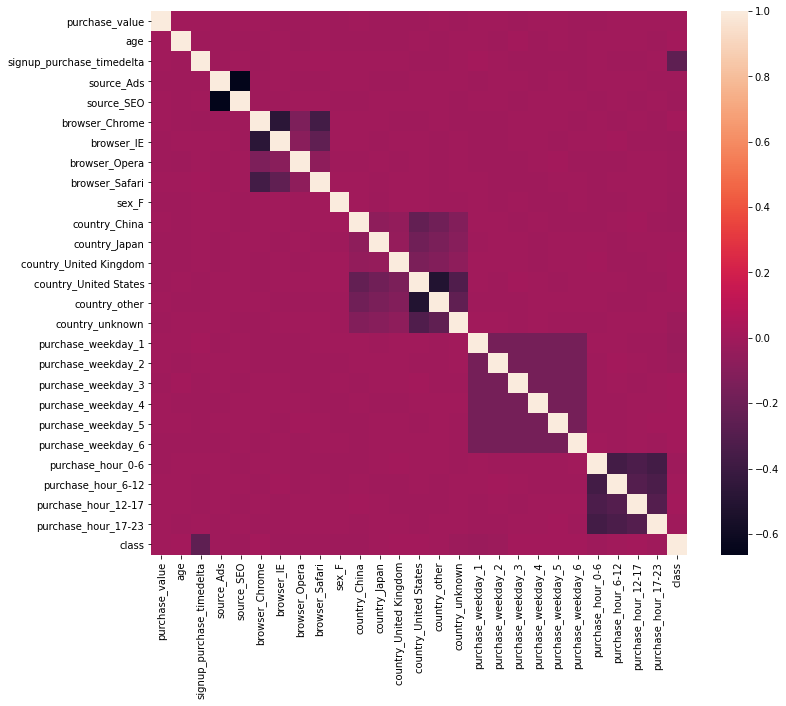

In [12]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(corr, annot=False, ax=ax);

plt.show()

##### train test split

In [13]:
def split_scale(df, features, target):
    X = df[features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
    
    # standardisation

    sc_X = StandardScaler().fit(X_train)
    X_train = sc_X.transform(X_train)
    X_test = sc_X.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [130]:
X_train, X_test, y_train, y_test = split_scale(df, features, target)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(120889, 26) (30223, 26) (120889, 1) (30223, 1)


In [15]:
def report_cm(y_real, y_pred, title="Confusion matrix"):
    
    print(classification_report(y_real, y_pred))

    cm = confusion_matrix(y_real, y_pred)

    fig, ax = plt.subplots(figsize=(12, 10))

    sns.heatmap(cm, annot=True, ax=ax, fmt="d");
    ax.set_xlabel("predicted")
    ax.set_ylabel("true")
    ax.set_title(title)

    plt.show()

### Calcul du "balanced" class weight

In [131]:
cw = class_weight.compute_class_weight("balanced", classes=y_train["class"].unique(), y=y_train.squeeze())

In [132]:
cw

array([0.55166198, 5.33914849])

In [133]:
cw = {i: v for i, v in enumerate(cw)}

### Logistic Regression

In [145]:
def logistic_search(param_grid):
    
    scorer = make_scorer(fbeta_score, beta=2)
    
    search = (GridSearchCV(LogisticRegression(n_jobs=-1, class_weight=cw), 
                           param_grid=param_grid, scoring=scorer, cv=10, n_jobs=-1)
              .fit(X_train, y_train.squeeze()))
    
    print(f"Logistic Regression best params : {search.best_params_}")
    
    logit = search.best_estimator_
    scores = cross_val_score(logit, X_train, y_train, cv=10, scoring=scorer, n_jobs=-1)
    
    print(f"F2-score, mean = {scores.mean()}, std = {scores.std()}")
          
    return logit, cross_val_predict(logit, X_train, y_train, cv=10, n_jobs=-1)

In [173]:
logit, y_pred = logistic_search(param_grid = {"C" : [0.05, 0.1, 0.5]})

Logistic Regression best params : {'C': 0.1}
Scores, mean = 0.43417353369435896, std = 0.01003778160435816


              precision    recall  f1-score   support

           0       0.96      0.64      0.77    109568
           1       0.17      0.71      0.27     11321

    accuracy                           0.65    120889
   macro avg       0.56      0.68      0.52    120889
weighted avg       0.88      0.65      0.72    120889



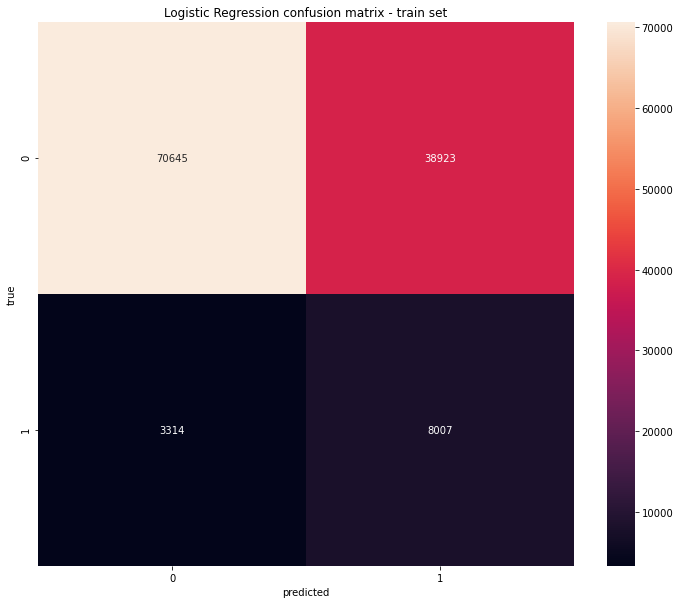

In [174]:
report_cm(y_train, y_pred, "Logistic Regression confusion matrix - train set")

### Bagging Logistic Regression

In [98]:
logistic_bagging = BaggingClassifier(logit, max_samples=0.9, 
                                     n_estimators=50, 
                                     n_jobs=-1).fit(X_train, y_train.squeeze())

              precision    recall  f1-score   support

           0       0.95      0.64      0.77    109568
           1       0.17      0.71      0.27     11321

    accuracy                           0.65    120889
   macro avg       0.56      0.67      0.52    120889
weighted avg       0.88      0.65      0.72    120889



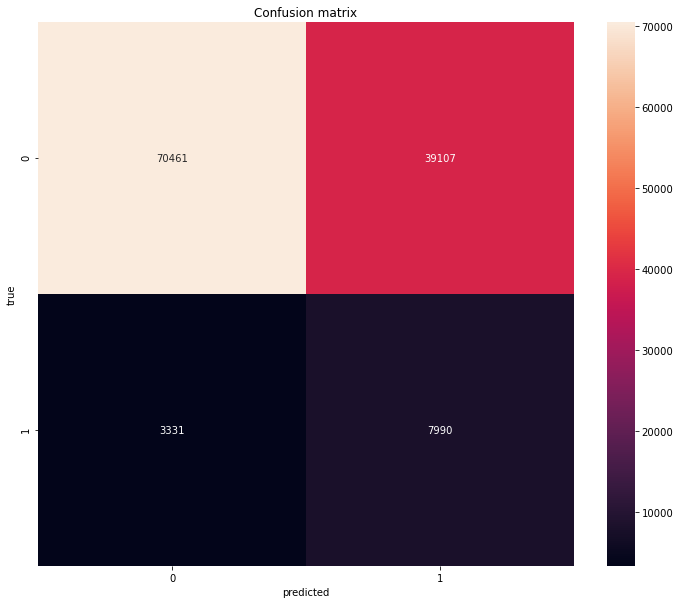

In [99]:
y_pred= logistic_bagging.predict(X_train)
report_cm(y_train, y_pred)

### Random Forest Classifier

In [168]:
def RF_search(param_grid):
    
    scorer = make_scorer(fbeta_score, beta=2)

    search = (GridSearchCV(RandomForestClassifier(max_features="sqrt", class_weight=cw, n_jobs=-1),
                           param_grid=param_grid, scoring=scorer, cv=10, n_jobs=-1)
              .fit(X_train, y_train.squeeze()))
    
    print(f"Random  forest best params : {search.best_params_}")
    
    rf_clf = search.best_estimator_
    scores = cross_val_score(rf_clf, X_train, y_train, cv=10, scoring=scorer, n_jobs=-1)
    print(f"F2-score : mean = {scores.mean()}, std = {scores.std()}")
    
    return rf_clf, rf_clf.predict(X_train)

In [181]:
%%notify -m "RF search terminé"
param_grid = {"max_depth": [10, None]}
rf_clf, y_pred = RF_search(param_grid)

Random  forest best params : {'max_depth': 10}
F2-score : mean = 0.5945893149740844, std = 0.013545883885310616


<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

           0       0.95      1.00      0.98    109568
           1       1.00      0.54      0.70     11321

    accuracy                           0.96    120889
   macro avg       0.98      0.77      0.84    120889
weighted avg       0.96      0.96      0.95    120889



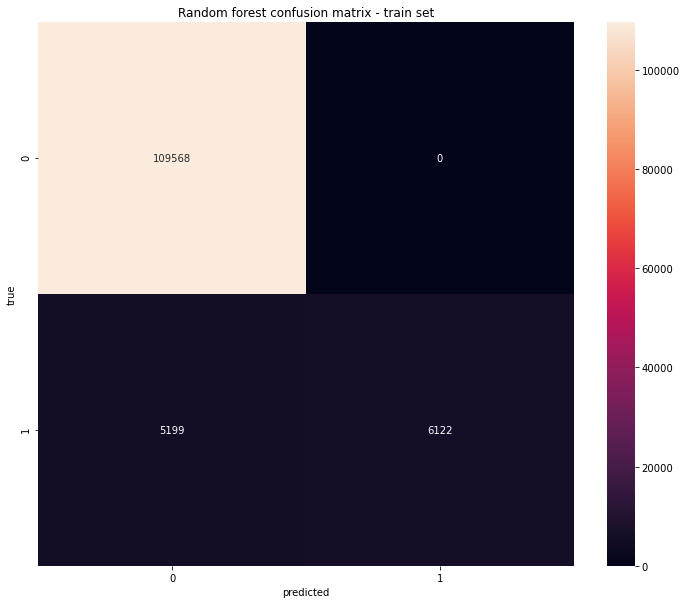

In [182]:
report_cm(y_train, y_pred, "Random forest confusion matrix - train set")

### ROC Curves

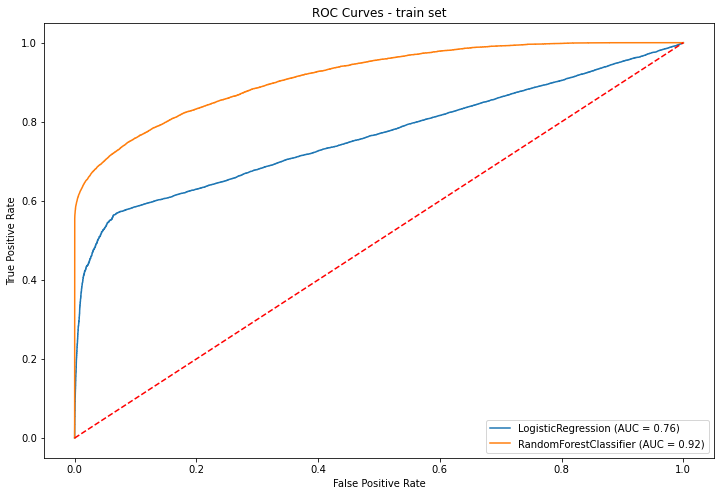

In [183]:
fig, ax = plt.subplots(figsize=(12, 8))

plot_roc_curve(logit, X_train, y_train, ax=ax)
plot_roc_curve(rf_clf, X_train, y_train, ax=ax)
ax.plot([0, 1], [0, 1], 'r--')
ax.set_title("ROC Curves - train set")

plt.show()
#fig.savefig('images/roc_curves.png', transparent=False, dpi=80, bbox_inches="tight")

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       1.00      0.53      0.69      2830

    accuracy                           0.96     30223
   macro avg       0.98      0.76      0.83     30223
weighted avg       0.96      0.96      0.95     30223



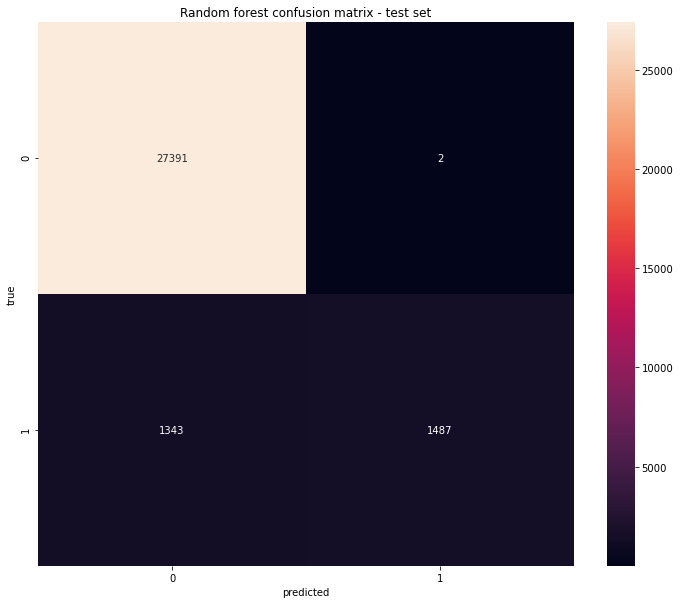

In [184]:
y_test_pred = cross_val_predict(rf_clf, X_test, y_test, cv=10, n_jobs=-1)
report_cm(y_test, y_test_pred, "Random forest confusion matrix - test set")

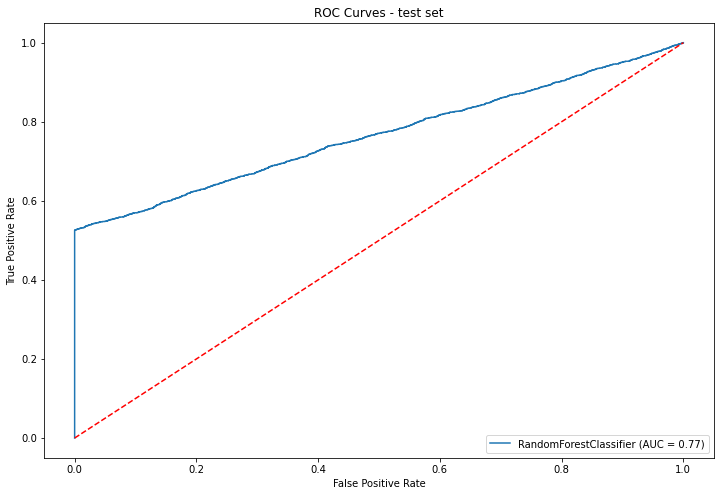

In [185]:
fig, ax = plt.subplots(figsize=(12, 8))

plot_roc_curve(rf_clf, X_test, y_test, ax=ax)
ax.plot([0, 1], [0, 1], 'r--')
ax.set_title("ROC Curves - test set")

plt.show()
#fig.savefig('images/roc_curves_test.png', transparent=False, dpi=80, bbox_inches="tight")

### Feature selection

In [156]:
time_features = [
    'signup_time',
    'purchase_time'
]

categorical = [
#1    'source_Ads',
#    'source_Direct', 
#1    'source_SEO', 
    'browser_Chrome',
#    'browser_FireFox', 
    'browser_IE', 
#1    'browser_Opera', 
    'browser_Safari', 
#    'sex_M',
    'sex_F',
#1    'country_China',
#1    'country_Japan', 
#    'country_Korea Republic of', 
#1    'country_United Kingdom',
    'country_United States', 
#2    'country_other', 
#1    'country_unknown',
#    'age_18-27', 
#    'age_27-33', 
#    'age_33-39', 
#    'age_39-76',
#1    'purchase_weekday_0', 
    'purchase_weekday_1', 
    'purchase_weekday_2',
#1    'purchase_weekday_3', 
    'purchase_weekday_4', 
#1    'purchase_weekday_5',
    'purchase_weekday_6', 
    'purchase_hour_0-6', 
    'purchase_hour_6-12',
#2    'purchase_hour_12-17', 
#2    'purchase_hour_17-23',
#2    "delta_1"
]

numerical = [
    "age",
    'purchase_value',
    "signup_purchase_timedelta"
]

features = numerical + categorical

target = ["class"]

In [157]:
X_train, X_test, y_train, y_test = split_scale(df, features, target)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(120889, 14) (30223, 14) (120889, 1) (30223, 1)


In [32]:
%%notify -m "RF Search terminé"
rf_clf, y_pred = RF_search(param_grid = {"n_estimators": [20, 50], "max_features": [5, 14]})

Random  forest best params : {'max_features': 5, 'n_estimators': 20}
Scores, mean = 0.9564725028561881, std = 0.001945840084209232


<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    109568
           1       1.00      0.95      0.97     11321

    accuracy                           0.99    120889
   macro avg       1.00      0.97      0.98    120889
weighted avg       0.99      0.99      0.99    120889



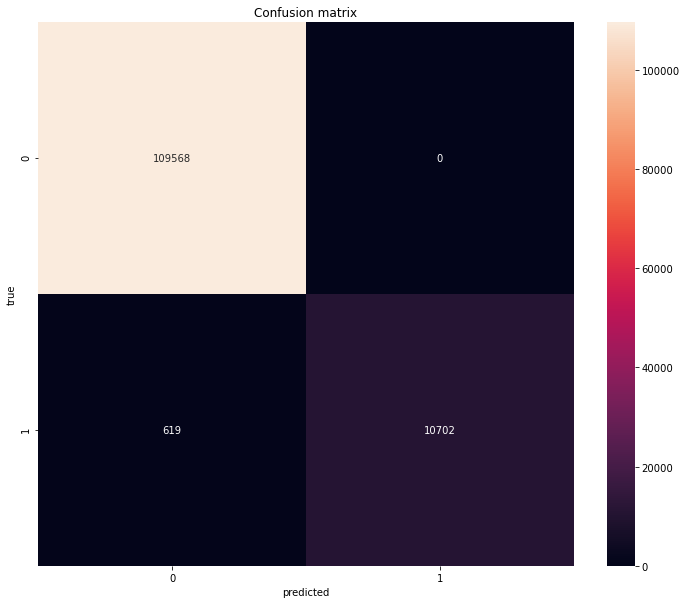

In [33]:
report_cm(y_train, y_pred)

In [34]:
# Poids des variables explicatives
feature_importance = pd.DataFrame({"Features": features,
                                   "Value": rf_clf.feature_importances_})

feature_importance.sort_values(["Value"], ascending=False)

,Features,Value
2,signup_purchase_timedelta,0.592395
1,purchase_value,0.156304
0,age,0.126070
6,sex_F,0.018470
7,country_United States,0.014598
12,purchase_hour_0-6,0.014226
4,browser_IE,0.011116
13,purchase_hour_6-12,0.010991
5,browser_Safari,0.010112
10,purchase_weekday_4,0.009978


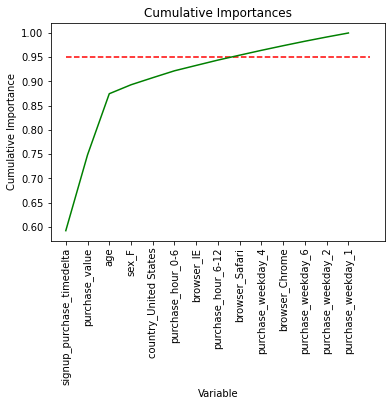

In [35]:
# Get numerical feature importances
importances = list(rf_clf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 6)) 
                       for feature, importance in zip(features, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)# Make a line graph

# list of x locations for plotting
x_values = list(range(len(importances)))
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable');
plt.ylabel('Cumulative Importance');
plt.title('Cumulative Importances');
plt.show()

### XGBoost

In [187]:
# gestion de l'équilibre des classes dans XGBoost

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
scale_pos_weight[0]

9.678296970232312

In [188]:
X_train, X_test, y_train, y_test = split_scale(df, features, target)

In [189]:
xgb_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight[0])

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)

scorer = make_scorer(fbeta_score, beta=2)

# evaluate model
scores = cross_val_score(xgb_model, X_train, y_train.squeeze(), scoring=scorer, cv=cv, n_jobs=-1)

# summarize performance
print('Mean F2-score: %.5f' % np.mean(scores))

Mean F2-score: 0.57785


In [190]:
xgb_model.fit(X_train, y_train.squeeze())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=9.678296970232312,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

              precision    recall  f1-score   support

           0       0.95      0.98      0.97    109568
           1       0.76      0.54      0.63     11321

    accuracy                           0.94    120889
   macro avg       0.86      0.76      0.80    120889
weighted avg       0.94      0.94      0.94    120889



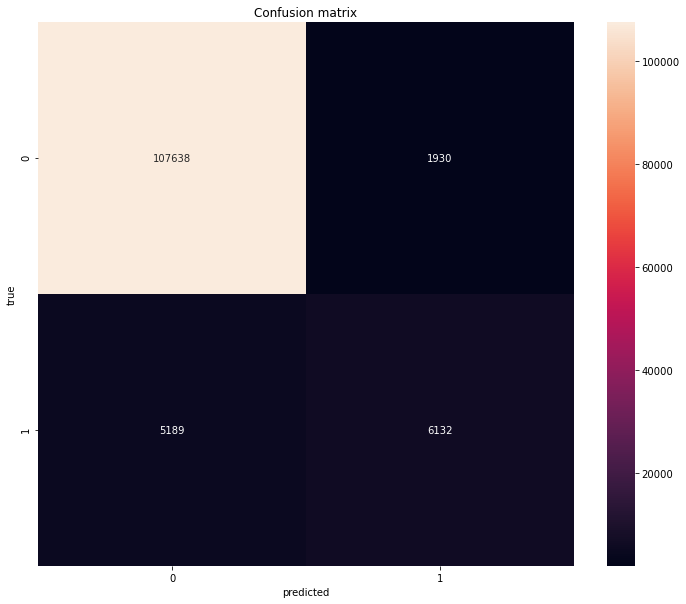

In [191]:
y_pred = cross_val_predict(xgb_model, X_train, y_train, cv=3, n_jobs=-1)
report_cm(y_train, y_pred)

### Stacking

In [199]:
estimators = [
    ('logit', logit),
    ('rf', rf_clf)
]

clf = StackingClassifier(estimators=estimators, final_estimator=xgb.XGBClassifier(n_jobs=-1), cv=5, n_jobs=-1)

clf.fit(X_train, y_train.squeeze())

StackingClassifier(cv=5,
                   estimators=[('logit',
                                LogisticRegression(C=0.1,
                                                   class_weight={0: 0.5516619816004673,
                                                                 1: 5.339148485116156},
                                                   n_jobs=-1)),
                               ('rf',
                                RandomForestClassifier(class_weight={0: 0.5516619816004673,
                                                                     1: 5.339148485116156},
                                                       max_depth=10,
                                                       max_features='sqrt',
                                                       n_jobs=-1))],
                   final_estimator=XGBClassifier(base_score=None, booster=None,
                                                 colsample_bylevel=None...
                                             

              precision    recall  f1-score   support

           0       0.95      1.00      0.98    109568
           1       1.00      0.53      0.69     11321

    accuracy                           0.96    120889
   macro avg       0.98      0.77      0.84    120889
weighted avg       0.96      0.96      0.95    120889



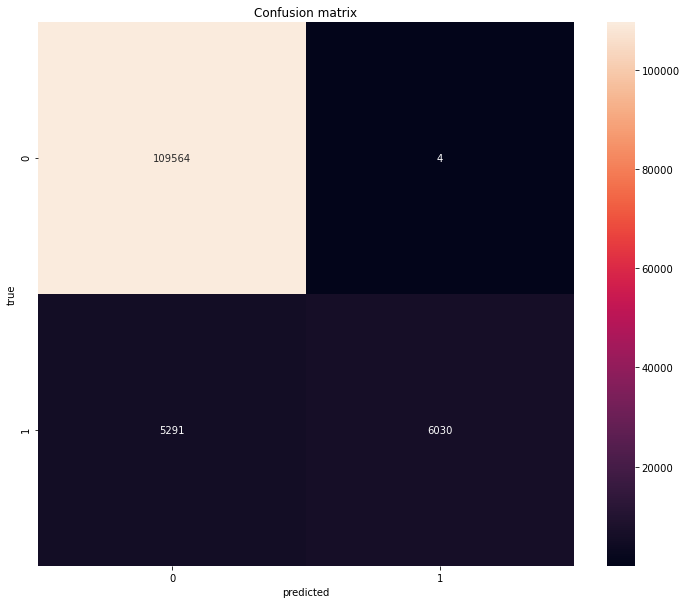

In [200]:
y_pred = cross_val_predict(clf, X_train, y_train, cv=5, n_jobs=-1)
report_cm(y_train, y_pred)

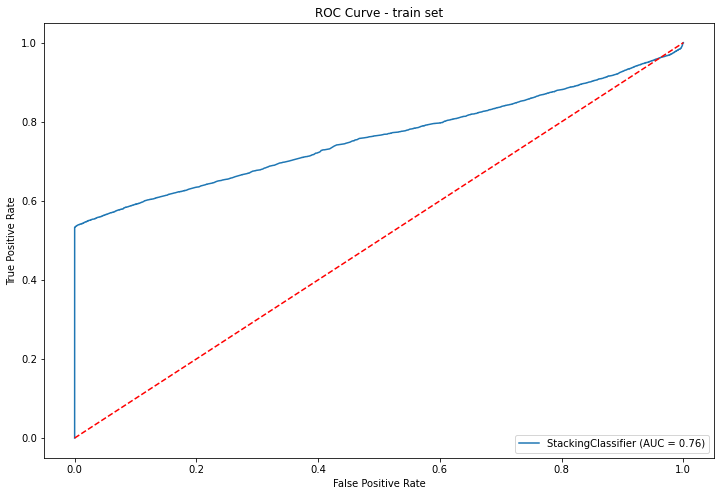

In [202]:
fig, ax = plt.subplots(figsize=(12, 8))

plot_roc_curve(clf, X_train, y_train, ax=ax)
ax.plot([0, 1], [0, 1], 'r--')
ax.set_title("ROC Curve - train set")

plt.show()
#fig.savefig('images/roc_curves_test.png', transparent=False, dpi=80, bbox_inches="tight")